# Use Python to evaluate chess positions in under two seconds.

I often watch chess games on lichess.org being played by Masters and Grandmasters. The level of these chess games and players is beyond my wildest dreams, and I often wonder who has the advantage. Rather than analyzing games afterward, I generally want to analyze them in real-time. So, I sought out a program to do this but found none. So, here it is!

The Python program below is optimized for lichess.org. But you can modify it for Chess.com or any chess website. It works by taking a screenshot of the chessboard, detecting where each piece is positioned on the board, drawing the chessboard using the python Chess library, then providing an evaluation and best move for the given position using the Stockfish engine.

**<center>The code below is intended for learning. Please do not use it to cheat.</center>**

#### Step 1: Importing required modules.
I used the OpenCV (Open Source Computer Vision Library) and NumPy libraries to screenshot the chessboard, visualize the chessboard squares, and compare differences between images. I encourage you to learn more about OpenCV if you are unfamiliar with it. Next, I used PIL (pillow) library to modify images (e.g., cropping). The CompareImages module uses OpenCV to find and highlight the differences between the two images. I slightly modified the code from CodeDeepAI, which is HERE, and you can download the module from my GitHub page. The mss library is a fast and easy way to grab a screenshot of the monitor and save the image as a PNG file. Next, I used the chess library for move generation, validation, and visualization. Finally, I used the stockfish engine for evaluating chess positions and identifying the best moves. You can download the Stockfish engine from their website. I am using Stockfish 14.1 (AVX2) in Windows for this project.

In [1]:
import cv2  # OpenCV library 
import numpy as np
import time

from PIL import Image # Pillow library will be used to open and crop images
from CompareImages import compare_images  # This code compares and detects differences 
                                          # between images.
from mss import mss # will be used for grabbing screenshots
sct=mss() 

import chess #used for chess baord visualization, move generation, and move validation.
from stockfish import Stockfish # The Stockfish chess engine will be used to evaluate 
                                # a given position and identify the top moves.
stockfish = Stockfish(r"Enter Your Path Here//stockfish.exe")

#### Step 2: Ensure the board is captured correctly.

Next, I created a function to locate the chessboard on the monitor. The function takes three inputs: the X- and Y-coordinates of the upper left corner of the chessboard and the width of each square on the chessboard. On my monitor, the X- and Y-coordinates were at pixels (585, 163), and the width of each square was 90 pixels (Image 1). You will need to configure these inputs for your monitor.

When you run the “capture_board” function, it will open a window that shows a live view of your monitor based on the input parameters. It will also draw an 8x8 grid. Ensure the blue boxes align closely with the chessboard squares (Image 2).

In [2]:
def capture_board(y_coords=163,x_coords=585, box_widths=90):
    
    global y_coord, x_coord, box_width
    y_coord, x_coord, box_width = y_coords, x_coords, box_widths
    
    
    '''
    This functions grabs a screenshot of your monitor based on the specified parameters. 
    It then draws an 8x8 grid based on the specified box width parameter. Make sure that 
    each blue square aligns closely with the chessboard squares.
    
    x_coord: This x coordinate is for the top left corner of the board. You will need to 
    modify it for your monitor.
    
    y_coord: This y coordinate is for the top left corner of the board. You will need to 
    modify it for your monitor.
    
    box_width: This is the width of each square on the chessboard. You may need to modify 
    it based on the size of your board.
    '''
    with mss() as sct:       
        monitor = {"top": y_coord, "left": x_coord, 
                   "width": (box_width)*8, "height": box_width*8}

        while True:
            screenshot = np.array(sct.grab(monitor))

            for i in range(1,8):
                # Draw 7 vericle blue lines with thickness of 3 px
                cv2.line(screenshot,((box_width)*i,0),((box_width)*i,
                                                       y_coord+(box_width)*8),
                         (255,0,0),3)

                # Draw 7 horizontal blue lines with thickness of 3 px
                cv2.line(screenshot,(0,(box_width)*i),(x_coord+(box_width)*8,
                                                       (box_width)*i),
                         (255,0,0),3)

            cv2.imshow('Chess Board', screenshot)
            if cv2.waitKey(1) == ord('q'):   # press any key to quit.
                cv2.destroyAllWindows()
                break

## Run the above function
capture_board(y_coords=163,x_coords=585, box_widths=90)

#### Step 3: Create a function that takes a screenshot of the chessboard and crops it according to the inputs above.

In the third step, I created a function that takes a single screenshot of the chessboard position based on the inputs from the capture_board function. This screenshot will be saved in the local directory and processed in the upcoming steps.

In [3]:
def take_screenshot(filename):
    ## Screen shot and then crop image
    filename1 = sct.shot(output=filename)
    im = Image.open(filename1)
                 # (left, upper, right         , lower         )
    im1 = im.crop(( x_coord  ,    y_coord, x_coord+box_width*8, y_coord+box_width*8))
    
    # Saves image in local directory
    im1.save(filename1)

#### Step 4 (optional): Identify if the board is flipped.

The function below detects whether the board is flipped. It works by detecting which rook (black or white) is in the upper left corner of the chessboard. This function may not work correctly if the game starts and the rooks have moved from their original positions. You can override this function by uncommenting “is_board_flipped=True” when the board is flipped or “is_board_flipped=False” when the board is not flipped (i.e., white is on the bottom of the chessboard).

In [4]:
def flipped_board():
    # Take a screenshot of the chessboard and save the image in local library.
    take_screenshot('InitialBoard.png')
    im = Image.open('InitialBoard.png')
    
    # Crop the upper left-hand sqaure and process it.
    im1 = im.crop((5, 5, 70, 70))
    im1.save('CurrentRook.png')
    image = cv2.imread('CurrentRook.png')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Assume the rook is white if the upper left-hand square has more than 300 white pixels.
    # otherwise, the rook is black and the board is not flipped.
    is_board_flipped=True if np.sum(gray==255)>300 else False
    return is_board_flipped

is_board_flipped=flipped_board()

# is_board_flipped=True
# is_board_flipped=False

print('Is the board flipped?', is_board_flipped)

Is the board flipped? False


#### Step 5: Orientation of the chessboard.

The array below will be arranged based on whether the board is flipped. I use the array in the next step for detecting which piece is on which square on the chessboard. If the board is not flipped, the square A1 will be in the lower left-hand corner; otherwise, the A1 square will be in the upper right-hand corner.

In [5]:
myList=[list(range(56,64)),
 list(range(48,56)),
 list(range(40,48)),
 list(range(32,40)),
 list(range(24,32)),
 list(range(16,24)),   
 list(range(8,16)),
 list(range(0,8))]

if is_board_flipped:
    myList.reverse()
    for i in range(8):
        myList[i].reverse()
myList

[[56, 57, 58, 59, 60, 61, 62, 63],
 [48, 49, 50, 51, 52, 53, 54, 55],
 [40, 41, 42, 43, 44, 45, 46, 47],
 [32, 33, 34, 35, 36, 37, 38, 39],
 [24, 25, 26, 27, 28, 29, 30, 31],
 [16, 17, 18, 19, 20, 21, 22, 23],
 [8, 9, 10, 11, 12, 13, 14, 15],
 [0, 1, 2, 3, 4, 5, 6, 7]]

#### Step 6: Identify chess pieces.

Only run this step once (assuming the size of the chessboard does not change between games). You can remove this section once you have identified the number of pixels per chess piece.

I wanted to find an easy, efficient, and consistent way to detect and identify chess pieces. Counting the number of black/white pixels on each chess square worked well.

The following code set arranges black and white pieces by the number of black and white pixels that make up each piece; note I did this step manually, but the order should be the same for you. You will notice the black king has the fewest number of black pixels, and the black knight has the largest number of black pixels. The white bishop has the smallest number of white pixels, and the white knight has the largest number of white pixels. The BPieceType and WPieceType align with the piece type assigned by the Chess library. You can read more about it in the Python Chess docs.

<u><b> Piece Types </b></u>
- Pawn = 1
- Knight = 2
- Bisphop = 3
- Rook = 4
- Queen = 5
- King = 6

In [6]:
# The pieces are arranged by the total number of black pixels. The black king has 
# the fewest number of black pixels, and the black knight has the largest number 
# of black pixels.
BPieces=['BlackKing','BlackBishop','BlackPawn','BlackRook','BlackQueen','BlackKnight']
BPieceType=[6,3,1,4,5,2]

# The pieces are arranged by the total number of white pixels. The white bishop has 
# the smallest number of white pixels, and the white knight has the largest number 
# of white pixels.
WPieces=['WhiteBishop','WhiteQueen','WhiteRook','WhitePawn','WhiteKing','WhiteKnight']
WPieceType=[3,5,4,1,6,2]

The <i>for loop</i> below will crop and save 64 images from the chessboard image provided. Each of the 64 images will align with a specific square based on the orientation specified in <b>Step 5</b>. Make sure you create a “Pieces” folder inside your main directory; the cropped images will be saved in this folder.

In [7]:
BlackPixelList, WhitePixelList=[],[]
nn=0;
n=0

# Take a screenshot of the entire chessboard and save the image
take_screenshot('image1.png')

#Read the chessboard into memory
image = cv2.imread('image1.png')

# Convert the color image to a gray scale image and save it.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('gray image.png', gray)
im = Image.open('gray image.png')


# Crop each squre of the chess board and save the 64 gray scale images. Each image 
# will align with a specific square on the chessboard.
for i in range(8):
    for j in range(8):

        im1=im.crop(
            (j*(box_width), 
             i*(box_width), 
             (j+1)*(box_width-0), 
             (i+1)*(box_width-0)))
        im1.save('pieces//'+str(nn)+'.png')
        n+=1        

        n=myList[i][j]
        image = cv2.imread('pieces//'+str(nn)+'.png')
        
        # count the number of black pixels per image
        BlackPiece=np.sum(image==0)
        BlackPixelList.append(BlackPiece)
        
        # count the number of white pixels per image
        WhitePiece=np.sum(image==255)
        WhitePixelList.append(WhitePiece)
        nn+=1

The code below aims to identify the number of black/white pixels for each chess piece. I have already created a list with the number of black and white pixels from above.

For each color, I do the following:
- keep unique pixel values
- sort the list in ascending order and keep the six largest pixel values
- each pixel value will align to the pieces specified in BPieces/WPieces

In [8]:
# Filter out values equal 0 and keep unique pixel values
# sort the list in ascending order
# keep the six largest pixel values
BlackPixelList=set(list(filter(lambda x: x > 0, BlackPixelList)))
BlackPixelList=list(BlackPixelList)
BlackPixelList.sort()
BlackPixelList=BlackPixelList[-6:]

WhitePixelList=set(list(filter(lambda x: x > 0, WhitePixelList)))
WhitePixelList=list(WhitePixelList)
WhitePixelList.sort()
WhitePixelList=WhitePixelList[-6:]

# Create a dictionary for each color and assign 
# pixel value to each chess piece, piece type,
# and piece color (False=Black, True=White).
BlackPieces={}
for i, val in enumerate(BPieces):
    BlackPieces[val] = (BlackPixelList[i],BPieceType[i],False)

WhitePieces={}
for i, val in enumerate(WPieces):
    WhitePieces[val] = (WhitePixelList[i],WPieceType[i],True)

In [9]:
BlackPieces

{'BlackKing': (5028, 6, False),
 'BlackBishop': (5052, 3, False),
 'BlackPawn': (5679, 1, False),
 'BlackRook': (6489, 4, False),
 'BlackQueen': (6495, 5, False),
 'BlackKnight': (7623, 2, False)}

In [10]:
WhitePieces

{'WhiteBishop': (2520, 3, True),
 'WhiteQueen': (3039, 5, True),
 'WhiteRook': (3741, 4, True),
 'WhitePawn': (3933, 1, True),
 'WhiteKing': (4410, 6, True),
 'WhiteKnight': (6057, 2, True)}

#### Step 7: Assign the number of pixels to each chess piece.

If this is the first time running the code, use the outputs from Step 6 to assign the number of black pixels for “BlackPieces” and the number of white pixels for the “WhitePieces.” The code below is an example given my monitor settings.

In [11]:
BlackPieces=\
{'BlackKing': (5028, 6, False),
 'BlackBishop': (5052, 3, False),
 'BlackPawn': (5679, 1, False),
 'BlackRook': (6489, 4, False),
 'BlackQueen': (6495, 5, False),
 'BlackKnight': (7623, 2, False)}

WhitePieces=\
{'WhiteBishop': (2520, 3, True),
 'WhiteQueen': (3039, 5, True),
 'WhiteRook': (3741, 4, True),
 'WhitePawn': (3933, 1, True),
 'WhiteKing': (4410, 6, True),
 'WhiteKnight': (6057, 2, True)}

BlackPixelValues=[i[0] for i in list(BlackPieces.values())]
WhitePixelValues=[i[0] for i in list(WhitePieces.values())]

#### Step 8: Set up a function to evaluate the board.

We’ve done all the set-up steps, and this is where the magic happens. We first start by setting up stockfish to be rated at 3000 ELO and set the depth to be 15. You can go up to a depth of 26, but that would significantly increase processing time. We then create the “evaluate_position” function. This function will:

- take a screenshot of the board
- convert the color image to grayscale and save the images
- identify where each chess piece is on the board and place those pieces in the appropriate position on the board using the chess library
- assign the turn to the specified color. The default is white’s turn.
- assign the FEN position in stockfish based on the position from the chess library
- generate requested output


In [12]:
stockfish.set_elo_rating(3000)
stockfish.set_depth(15)

def evaluate_position(white_turn=True, board_flipped=is_board_flipped):
    start_time = time.time()
    # take a screenshot of the board
    take_screenshot('image1.png')
    image = cv2.imread('image1.png')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('gray image.png', gray)
    im = Image.open('gray image.png')

    # Set up the board from the Chess library
    board = chess.Board()
    # Remove all the pieces because they will be specified in the next step
    board.clear()
    # Set the turn to White to play, unless otherwise specified
    board.turn = white_turn 

    nn=0;
    n=0
    for i in range(8):
        for j in range(8):

            im1=im.crop((j*(box_width), i*(box_width), (j+1)*(box_width-0), (i+1)*(box_width-0)))
            im1.save('pieces//'+str(nn)+'.png')
            n+=1        

            n=myList[i][j]
            # Read each cropped chess square and identify the chess piece and color.
            image = cv2.imread('pieces//'+str(nn)+'.png')
            BlackPiece=np.sum(image==0)
            WhitePiece=np.sum(image==255)
            res_val=(0,0,True)
            if BlackPiece>min(BlackPixelValues)-50:
                # Identify the chess piece based on he number of black pixels closest to the 
                # values from the BlackPieces dictionary.
                col_key, res_val = min(BlackPieces.items(), key=lambda x: abs(BlackPiece - x[1][0]))
            if WhitePiece>min(WhitePixelValues)-50:
                # Identify the chess piece based on he number of white pixels closest to the 
                # values from the BlackPieces dictionary.
                col_key, res_val = min(WhitePieces.items(), key=lambda x: abs(WhitePiece - x[1][0]))
            # set the chess piece on the board based on it position, piece type, and color. 
            board.set_piece_at(n,piece=chess.Piece(piece_type=res_val[1],color=res_val[2]))
            nn+=1

    #create the FEN based on the current position 
    turn_fen=' w - - 1 0' if board.turn == True else ' b - - 0 1'
    current_fen=board.board_fen()+turn_fen
    # Assign the postion in Stockfish based on FEN
    stockfish.set_fen_position(current_fen)
    # Get the top moves
    top_moves=stockfish.get_top_moves()
    #Get the best move
    my_move=top_moves[0]['Move']
    # Move the chess piece based on the best move
    board.push(chess.Move.from_uci(my_move))

    #Create output
    print('Time:',time.time()-start_time)
    print('Best Move:', my_move)
    print('Evaluation:', stockfish.get_evaluation())
    print('Top moves:')
    for i in top_moves:
        print(i)

    if board_flipped:
        board.apply_transform(chess.flip_vertical)
        board.apply_transform(chess.flip_horizontal)
        display(board)
    else:
        display(board)

#### Step 9: Run the chessboard evaluation.

Congratulations, you are done! Specify whether it is white’s turn (set white_turn=True) or black’s turn (white_turn=False) and run the evaluation function. The function will output:

- the time it took to run the function
- the best-calculated move
- an evaluation of the current position
- the top moves
- a visual of the current position and the next best move

Re-run the evaluate_postition function if the position changes; you do not need to re-run the previous steps.

Time: 1.5966980457305908
Best Move: d2d4
Evaluation: {'type': 'cp', 'value': 24}
Top moves:
{'Move': 'd2d4', 'Centipawn': 33, 'Mate': None}
{'Move': 'b1c3', 'Centipawn': 27, 'Mate': None}
{'Move': 'f1c4', 'Centipawn': 14, 'Mate': None}
{'Move': 'a2a3', 'Centipawn': 3, 'Mate': None}
{'Move': 'f1b5', 'Centipawn': -2, 'Mate': None}


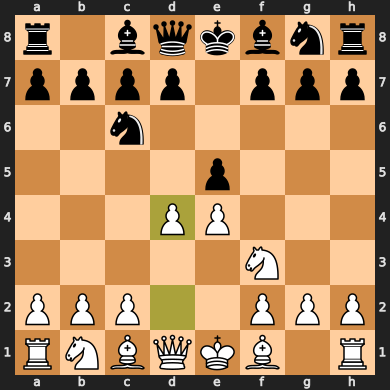

In [13]:
evaluate_position(white_turn=True)

In [ ]:
evaluate_position(white_turn=False)